# 변경
기준일자 변수 이용하여 요일변수 생성  
시도명 -> 모두 부산광역시 이므로 제거  
행정동명, 행정동 번호 모두 같은것이므로 행정동번호 제거  
업종명, 업종코드 모두 같은것이므로 업종코드 제거  
출생년도 4067,3688 제거  
출생년도 변수 이용하여 연령대 변수 생성  
거래건수 처리 생각  
외부 데이터 이용하여 구 인구 수, 연령대 찾고 비교해볼 예정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from sklearn.metrics import f1_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [2]:
path = "C:/Users/ekgus/Desktop/카드소비/"

In [3]:
os.listdir(path)

['.ipynb_checkpoints',
 'august.csv',
 'card_dh.ipynb',
 'DownloadData_20230304121208.zip',
 'EX_F_BBP23_00019.csv',
 'httpswww.bigdata-finance.krdatasetd.txt',
 'july.csv',
 'june.csv']

In [4]:
june = pd.read_csv("june.csv",encoding = 'cp949',low_memory =False)

In [5]:
july = pd.read_csv("july.csv", encoding = 'cp949', low_memory =False)

In [6]:
august = pd.read_csv("august.csv", encoding = 'cp949', low_memory = False)

In [7]:
print("june", len(june))
print("july", len(july))
print("august", len(august))
s = len(june) + len(july) + len(august)
s

june 10061735
july 9756266
august 7317159


27135160

In [8]:
df = pd.concat([june, july,august], ignore_index=True)
print(df)

          strd_date  strd_tizn_val ctpr_nm ccg_nm adn_dgnm   adng_no cardc_nm  \
0          20220601              0   부산광역시     중구      대청동  21010530       코나   
1          20220601              0   부산광역시     중구      중앙동  21010510       부산   
2          20220601              0   부산광역시     중구      중앙동  21010510       부산   
3          20220601              0   부산광역시     중구      중앙동  21010510       부산   
4          20220601              0   부산광역시     중구      중앙동  21010510       코나   
...             ...            ...     ...    ...      ...       ...      ...   
27135155   20220801              0   부산광역시    영도구     동삼1동  21040650       코나   
27135156   20220801              0   부산광역시    영도구     동삼1동  21040650       코나   
27135157   20220801              0   부산광역시    영도구     동삼1동  21040650       코나   
27135158   20220801              0   부산광역시    영도구     동삼1동  21040650       하나   
27135159   20220801              0   부산광역시    영도구     동삼1동  21040650       하나   

          tpbuz_cd tpbuz_nm

In [9]:
print(df.isnull().sum())

strd_date        0
strd_tizn_val    0
ctpr_nm          0
ccg_nm           0
adn_dgnm         0
adng_no          0
cardc_nm         0
tpbuz_cd         0
tpbuz_nm         0
bth_yr           0
sex_cd           0
trns_cnt         0
ttl_trns_amt     0
dtype: int64


In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27135160 entries, 0 to 27135159
Data columns (total 13 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   strd_date      int64 
 1   strd_tizn_val  int64 
 2   ctpr_nm        object
 3   ccg_nm         object
 4   adn_dgnm       object
 5   adng_no        int64 
 6   cardc_nm       object
 7   tpbuz_cd       int64 
 8   tpbuz_nm       object
 9   bth_yr         int64 
 10  sex_cd         object
 11  trns_cnt       int64 
 12  ttl_trns_amt   int64 
dtypes: int64(7), object(6)
memory usage: 2.6+ GB
None


In [11]:
df = df.rename(columns = {'strd_date':'기준일자', 'strd_tizn_val':'기준시간대값', 'ctpr_nm':'시도명', 'ccg_nm':'시군구명', 'adn_dgnm':'행정동명',
       'adng_no':'행정동번호', 'cardc_nm':'카드사명', 'tpbuz_cd':'업종코드', 'tpbuz_nm':'업종명', 'bth_yr':'출생년도', 'sex_cd':'성별코드',
       'trns_cnt':'거래건수', 'ttl_trns_amt':'총거래금액'})

In [12]:
df.head()

,기준일자,기준시간대값,시도명,시군구명,행정동명,행정동번호,카드사명,업종코드,업종명,출생년도,성별코드,거래건수,총거래금액
0,20220601,0,부산광역시,중구,대청동,21010530,코나,4010,편 의 점,1973,M,1,7350
1,20220601,0,부산광역시,중구,중앙동,21010510,부산,4010,편 의 점,1981,F,1,3700
2,20220601,0,부산광역시,중구,중앙동,21010510,부산,4010,편 의 점,1992,M,1,7500
3,20220601,0,부산광역시,중구,중앙동,21010510,부산,4010,편 의 점,1995,M,1,2700
4,20220601,0,부산광역시,중구,중앙동,21010510,코나,4010,편 의 점,1976,M,1,13900


In [13]:
df.describe()

,기준일자,기준시간대값,행정동번호,업종코드,출생년도,거래건수,총거래금액
count,2.713516e+07,2.713516e+07,2.713516e+07,2.713516e+07,2.713516e+07,2.713516e+07,2.713516e+07
mean,2.022070e+07,1.466897e+01,2.110182e+07,6.238941e+03,1.977280e+03,1.102882e+00,2.237177e+04
std,7.979648e+01,4.456955e+00,8.615880e+04,2.131983e+03,1.484848e+01,3.846163e-01,4.577845e+04
min,2.022060e+07,0.000000e+00,2.101051e+07,1.001000e+03,1.921000e+03,1.000000e+00,1.000000e+00
25%,2.022062e+07,1.200000e+01,2.106055e+07,4.020000e+03,1.967000e+03,1.000000e+00,4.400000e+03
50%,2.022071e+07,1.500000e+01,2.109064e+07,7.050000e+03,1.978000e+03,1.000000e+00,9.000000e+03
75%,2.022080e+07,1.800000e+01,2.112059e+07,8.006000e+03,1.989000e+03,1.000000e+00,2.200000e+04
max,2.022083e+07,2.300000e+01,2.151033e+07,9.998000e+03,4.607000e+03,7.100000e+01,2.413460e+06


In [14]:
#평균, 표준편차, quantile확인 -> trns_cnt 생각해볼 필요
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

,기준일자,기준시간대값,행정동번호,업종코드,출생년도,거래건수,총거래금액
count,27135160.00,27135160.00,27135160.00,27135160.00,27135160.00,27135160.00,27135160.00
mean,20220704.85,14.67,21101816.97,6238.94,1977.28,1.10,22371.77
std,79.80,4.46,86158.80,2131.98,14.85,0.38,45778.45
min,20220601.00,0.00,21010510.00,1001.00,1921.00,1.00,1.00
25%,20220620.00,12.00,21060550.00,4020.00,1967.00,1.00,4400.00
50%,20220711.00,15.00,21090640.00,7050.00,1978.00,1.00,9000.00
75%,20220802.00,18.00,21120590.00,8006.00,1989.00,1.00,22000.00
max,20220831.00,23.00,21510330.00,9998.00,4607.00,71.00,2413460.00


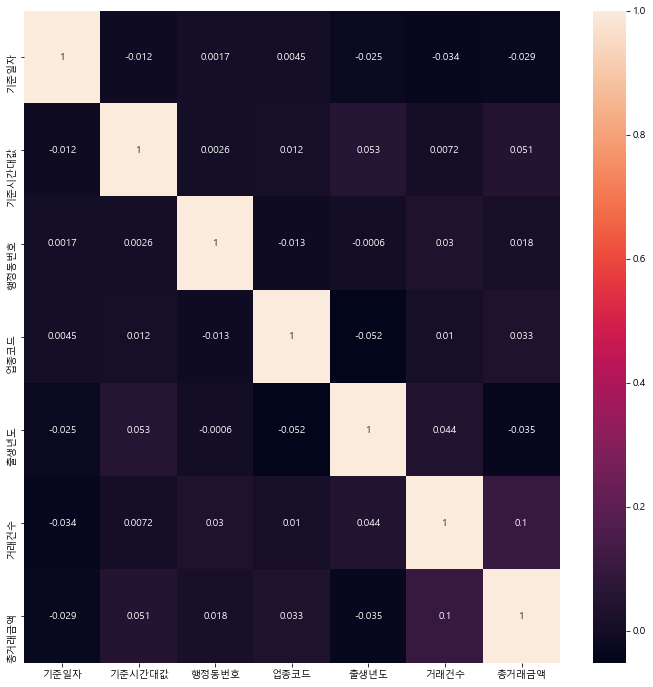

In [16]:
#변수 상관관계 확인 ->큰 상관관계 보이지 않음.
plt.figure(figsize = (12, 12))
sns.heatmap(df.corr(), annot = True)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'Malgun Gothic' #->한글 안깨지게

# strd_date 기준일자

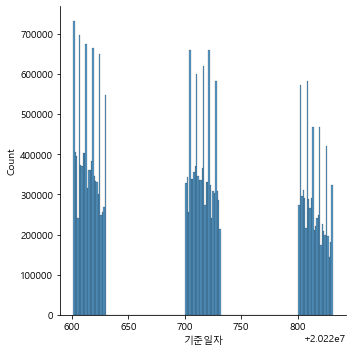

In [17]:
sns.displot(data=df,x='기준일자')
plt.show()
#->확인 안해도 될것같음

In [18]:
#월,일자 별 갯수 확인
df['기준일자'].value_counts()

20220603    405347
20220611    402782
20220610    402468
20220604    394645
20220617    382423
             ...  
20220829    182203
20220821    173513
20220830    166013
20220831    157670
20220828    144124
Name: 기준일자, Length: 92, dtype: int64

In [19]:
#월 별 갯수 확인위해 slice
sliced = df['기준일자'].astype(str).str[:6]
print(sliced)

0           202206
1           202206
2           202206
3           202206
4           202206
             ...  
27135155    202208
27135156    202208
27135157    202208
27135158    202208
27135159    202208
Name: 기준일자, Length: 27135160, dtype: object


In [20]:
dataslice = sliced.value_counts()
dataslice
#6월이 가장 많음 확인

202206    10061735
202207     9756266
202208     7317159
Name: 기준일자, dtype: int64

In [21]:
#strd_date type변환
df=df.astype({'기준일자' : str})

In [22]:
df['기준일자']=pd.to_datetime(df['기준일자'])

In [23]:
df.head()

,기준일자,기준시간대값,시도명,시군구명,행정동명,행정동번호,카드사명,업종코드,업종명,출생년도,성별코드,거래건수,총거래금액
0,2022-06-01,0,부산광역시,중구,대청동,21010530,코나,4010,편 의 점,1973,M,1,7350
1,2022-06-01,0,부산광역시,중구,중앙동,21010510,부산,4010,편 의 점,1981,F,1,3700
2,2022-06-01,0,부산광역시,중구,중앙동,21010510,부산,4010,편 의 점,1992,M,1,7500
3,2022-06-01,0,부산광역시,중구,중앙동,21010510,부산,4010,편 의 점,1995,M,1,2700
4,2022-06-01,0,부산광역시,중구,중앙동,21010510,코나,4010,편 의 점,1976,M,1,13900


In [24]:
from datetime import datetime
df['기준일자']

0          2022-06-01
1          2022-06-01
2          2022-06-01
3          2022-06-01
4          2022-06-01
              ...    
27135155   2022-08-01
27135156   2022-08-01
27135157   2022-08-01
27135158   2022-08-01
27135159   2022-08-01
Name: 기준일자, Length: 27135160, dtype: datetime64[ns]

In [25]:
#day_name(요일) 생성
df['요일']=df['기준일자'].dt.day_name()
df

,기준일자,기준시간대값,시도명,시군구명,행정동명,행정동번호,카드사명,업종코드,업종명,출생년도,성별코드,거래건수,총거래금액,요일
0,2022-06-01,0,부산광역시,중구,대청동,21010530,코나,4010,편 의 점,1973,M,1,7350,Wednesday
1,2022-06-01,0,부산광역시,중구,중앙동,21010510,부산,4010,편 의 점,1981,F,1,3700,Wednesday
2,2022-06-01,0,부산광역시,중구,중앙동,21010510,부산,4010,편 의 점,1992,M,1,7500,Wednesday
3,2022-06-01,0,부산광역시,중구,중앙동,21010510,부산,4010,편 의 점,1995,M,1,2700,Wednesday
4,2022-06-01,0,부산광역시,중구,중앙동,21010510,코나,4010,편 의 점,1976,M,1,13900,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27135155,2022-08-01,0,부산광역시,영도구,동삼1동,21040650,코나,4020,슈퍼마켓,1958,M,1,30000,Monday
27135156,2022-08-01,0,부산광역시,영도구,동삼1동,21040650,코나,8013,주점,1998,M,1,59600,Monday
27135157,2022-08-01,0,부산광역시,영도구,동삼1동,21040650,코나,8399,기타음료식품,1998,F,1,7500,Monday
27135158,2022-08-01,0,부산광역시,영도구,동삼1동,21040650,하나,4010,편 의 점,1971,F,2,7600,Monday


# strd_tizn_val 기준시간대값

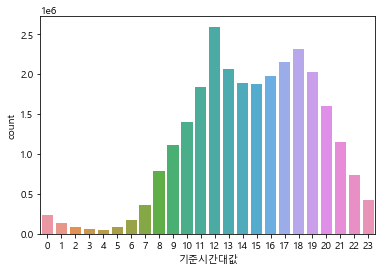

In [26]:
sns.countplot(data=df, x="기준시간대값")
plt.show()

12    2594249
18    2317544
17    2149852
13    2064385
19    2022080
16    1973444
14    1884563
15    1879940
11    1835542
20    1602146
10    1396157
21    1145898
9     1115819
8      790217
22     732863
23     423246
7      365718
0      236182
6      176698
1      141841
2       89931
5       84899
3       59274
4       52672
Name: 기준시간대값, dtype: int64


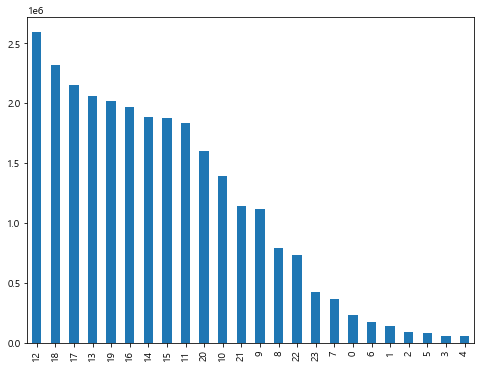

In [27]:
df.기준시간대값.value_counts().plot.bar(figsize=(8,6))
print(df.기준시간대값.value_counts())
#12시가 가장 많고, 그다음 18시가 많음

기준시간대값
0    15800.09
1    15308.09
2    13455.86
3    12611.47
4    12234.27
5    15096.61
6    16306.93
7    13849.94
8    11390.90
9    17231.34
10   21452.52
11   21741.54
12   20856.30
13   22486.68
14   24141.43
15   24454.01
16   24028.62
17   23696.53
18   24084.36
19   26627.30
20   26829.50
21   23226.25
22   19304.12
23   17664.32
Name: 총거래금액, dtype: float64

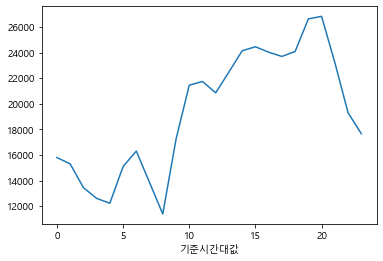

In [28]:
#시간대별 총 거래금액 평균 확인 -> 20시가 가장 많음
df.groupby(['기준시간대값'])['총거래금액'].mean().plot()
df.groupby(['기준시간대값'])['총거래금액'].mean()

# ctpr_nm 시도명

In [29]:
df.시도명.unique()

array(['부산광역시'], dtype=object)

In [30]:
#데이터 전체가 부산광역시 이므로 제거
df=df.drop(['시도명'], axis=1)

In [31]:
df.head()

,기준일자,기준시간대값,시군구명,행정동명,행정동번호,카드사명,업종코드,업종명,출생년도,성별코드,거래건수,총거래금액,요일
0,2022-06-01,0,중구,대청동,21010530,코나,4010,편 의 점,1973,M,1,7350,Wednesday
1,2022-06-01,0,중구,중앙동,21010510,부산,4010,편 의 점,1981,F,1,3700,Wednesday
2,2022-06-01,0,중구,중앙동,21010510,부산,4010,편 의 점,1992,M,1,7500,Wednesday
3,2022-06-01,0,중구,중앙동,21010510,부산,4010,편 의 점,1995,M,1,2700,Wednesday
4,2022-06-01,0,중구,중앙동,21010510,코나,4010,편 의 점,1976,M,1,13900,Wednesday


# ccg_nm 시군구명

In [38]:
df.시군구명.unique()

array(['중구', '서구', '동구', '영도구', '부산진구', '동래구', '남구', '북구', '해운대구', '사하구',
       '금정구', '강서구', '연제구', '수영구', '사상구', '기장군'], dtype=object)

In [32]:
# 시군구명 별 갯수 확인
df['시군구명'].value_counts()

부산진구    3568514
해운대구    3075269
동래구     2504967
금정구     2151442
사하구     2004888
북구      1995622
연제구     1912041
남구      1881526
수영구     1595591
사상구     1489445
강서구     1336118
기장군      963690
동구       726398
서구       691524
중구       655696
영도구      582429
Name: 시군구명, dtype: int64

In [33]:
#시군구 별 평균 총거래금액 확인
df.groupby(['시군구명'])['총거래금액'].mean()

시군구명
강서구    26168.16
금정구    20321.70
기장군    26240.25
남구     20809.73
동구     18813.50
동래구    23766.31
부산진구   22537.32
북구     22295.89
사상구    22084.73
사하구    21336.54
서구     19153.76
수영구    22494.45
연제구    21918.37
영도구    18426.61
중구     22606.10
해운대구   23914.71
Name: 총거래금액, dtype: float64

In [35]:
#정렬
sorted_numbers = sorted(df.groupby(['시군구명'])['총거래금액'].mean(), reverse=True)
print(sorted_numbers)  

#기장군이 가장 많음

[26240.252182755867, 26168.15913938739, 23914.713931366656, 23766.311139028978, 22606.101690417512, 22537.32074387266, 22494.44608361416, 22295.88654765281, 22084.73157652683, 21918.368514064292, 21336.540397767854, 20809.734704170976, 20321.696546316376, 19153.764236671468, 18813.496190793478, 18426.611664254357]


In [36]:
#시군구별 연령대 평균
df.groupby(['시군구명'])['출생년도'].mean()
#강서구 가장 낮고, 동래구가 가장 높아보임 -> 외부 데이터 이용하여 확인해볼 예정

시군구명
강서구    1978.97
금정구    1978.35
기장군    1977.32
남구     1977.95
동구     1976.92
동래구    1976.37
부산진구   1978.38
북구     1976.64
사상구    1977.13
사하구    1976.57
서구     1976.99
수영구    1977.07
연제구    1976.39
영도구    1975.77
중구     1977.46
해운대구   1976.85
Name: 출생년도, dtype: float64

# adn_dgnm 행정동명

In [37]:
df.행정동명.unique()

array(['대청동', '중앙동', '동광동', '서대신3동', '서대신4동', '부민동', '아미동', '초장동', '충무동',
       '남부민1동', '암남동', '남부민2동', '초량1동', '초량2동', '범일1동', '남항동', '영선1동',
       '영선2동', '봉래1동', '청학1동', '청학2동', '동삼1동', '부전2동', '연지동', '초읍동',
       '양정1동', '양정2동', '전포2동', '당감2동', '당감4동', '가야2동', '개금1동', '개금2동',
       '가야1동', '부전1동', '전포1동', '수민동', '복산동', '온천1동', '온천2동', '사직2동',
       '사직3동', '안락1동', '안락2동', '명륜동', '대연3동', '대연4동', '대연5동', '대연6동',
       '용호1동', '용호2동', '용호3동', '용호4동', '용당동', '감만1동', '감만2동', '문현1동',
       '문현2동', '문현3동', '문현4동', '대연1동', '우암동', '구포1동', '구포2동', '구포3동',
       '금곡동', '화명1동', '덕천1동', '덕천2동', '덕천3동', '만덕1동', '만덕2동', '만덕3동',
       '화명2동', '화명3동', '중1동', '중2동', '송정동', '반여2동', '반여3동', '반송2동',
       '재송1동', '재송2동', '좌1동', '좌2동', '좌3동', '좌4동', '반여1동', '반여4동', '반송1동',
       '우1동', '우2동', '우3동', '괴정1동', '괴정2동', '괴정3동', '괴정4동', '당리동', '하단1동',
       '하단2동', '신평1동', '신평2동', '장림1동', '장림2동', '다대1동', '다대2동', '구평동',
       '감천1동', '감천2동', '서2동', '부곡1동', '부곡2동', '부곡3동', '부곡4동', '장전1동',
       '

In [38]:
#행정동 별 개수

#pd.set_option('display.max_rows', None) -> 행 전체 나오는 코드
df['행정동명'].value_counts()

#-> 행정동번호와 일치하는지 확인 후 삭제

명지1동    620513
부전2동    528260
장전2동    509024
대연3동    494648
정관읍     477624
         ...  
모라3동      8386
신선동       6463
수정5동      6258
수정4동      6114
초장동       2240
Name: 행정동명, Length: 205, dtype: int64

# adng_no 행정동번호

In [32]:
df.행정동번호.unique()

array([21010530, 21010510, 21010520, 21020560, 21020570, 21020590,
       21020610, 21020630, 21020640, 21020650, 21020680, 21020690,
       21030510, 21030520, 21030710, 21040530, 21040540, 21040550,
       21040590, 21040630, 21040640, 21040650, 21050520, 21050540,
       21050550, 21050560, 21050570, 21050610, 21050680, 21050700,
       21050720, 21050740, 21050750, 21050810, 21050820, 21050830,
       21060510, 21060520, 21060550, 21060560, 21060590, 21060600,
       21060610, 21060620, 21060650, 21070530, 21070540, 21070550,
       21070560, 21070570, 21070580, 21070590, 21070600, 21070610,
       21070620, 21070630, 21070660, 21070670, 21070680, 21070690,
       21070700, 21070710, 21080510, 21080520, 21080530, 21080540,
       21080550, 21080560, 21080570, 21080580, 21080590, 21080600,
       21080610, 21080620, 21080630, 21090530, 21090540, 21090560,
       21090580, 21090590, 21090620, 21090640, 21090650, 21090660,
       21090670, 21090680, 21090690, 21090700, 21090710, 21090

In [39]:
#pd.set_option('display.max_rows', None)
df['행정동번호'].value_counts()

21120590    620513
21050520    528260
21110740    509024
21070530    494648
21510130    477624
             ...  
21150540      8386
21040680      6463
21030600      6258
21030590      6114
21020630      2240
Name: 행정동번호, Length: 205, dtype: int64

In [40]:
len(df['행정동명'].unique())

205

In [41]:
# 행정동명과 행정동 번호가 1:1 매칭이라면 둘 중 한 정보만 써도 될 것이다.
# == 만약 부산에 같은 동 이름을 가진 동네가 여러개가 아니라면..

df.groupby('행정동명')['행정동번호'].nunique().sum()

#행정동 번호와 행정동명 유니크 개수가 같음.-> 행정동번호 제거

205

In [42]:
df=df.drop(['행정동번호'], axis=1)
df

,기준일자,기준시간대값,시군구명,행정동명,카드사명,업종코드,업종명,출생년도,성별코드,거래건수,총거래금액,요일
0,2022-06-01,0,중구,대청동,코나,4010,편 의 점,1973,M,1,7350,Wednesday
1,2022-06-01,0,중구,중앙동,부산,4010,편 의 점,1981,F,1,3700,Wednesday
2,2022-06-01,0,중구,중앙동,부산,4010,편 의 점,1992,M,1,7500,Wednesday
3,2022-06-01,0,중구,중앙동,부산,4010,편 의 점,1995,M,1,2700,Wednesday
4,2022-06-01,0,중구,중앙동,코나,4010,편 의 점,1976,M,1,13900,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...
27135155,2022-08-01,0,영도구,동삼1동,코나,4020,슈퍼마켓,1958,M,1,30000,Monday
27135156,2022-08-01,0,영도구,동삼1동,코나,8013,주점,1998,M,1,59600,Monday
27135157,2022-08-01,0,영도구,동삼1동,코나,8399,기타음료식품,1998,F,1,7500,Monday
27135158,2022-08-01,0,영도구,동삼1동,하나,4010,편 의 점,1971,F,2,7600,Monday


# cardc_nm 카드사명

In [43]:
df.카드사명.unique()

array(['코나', '부산', '하나', '동백택시', '농협', 'QR'], dtype=object)

In [44]:
#카드사명 별 사용개수 확인 -> 코나 (:코나아이) 가장 많이 사용
df['카드사명'].value_counts()

코나      14474787
하나       6781004
부산       5358627
농협        346273
동백택시      144603
QR         29866
Name: 카드사명, dtype: int64

In [45]:
#그래프로 확인
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' #->한글 안깨지게

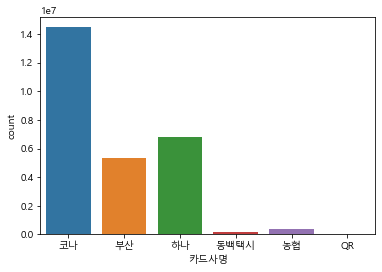

In [46]:
sns.countplot(data=df, x="카드사명")
plt.show()

# tpbuz_cd 업종코드

In [48]:
df.업종코드.unique()

array([4010, 9130, 2102, 8001, 4020, 1123, 4021, 8310, 8320, 8021, 8399,
       2114, 8006, 2130, 8013, 2199, 8004, 2240, 3402, 6140, 8301, 8010,
       3305, 8005, 3306, 9305, 9204, 1020, 4499, 3309, 2121, 3307, 5191,
       2111, 5299, 4201, 9210, 3301, 2002, 9101, 5104, 3311, 7120, 5201,
       5101, 2112, 9301, 9398, 5010, 3001, 5199, 6130, 3308, 9901, 3102,
       3313, 9699, 5105, 2001, 8002, 8302, 4099, 2120, 4050, 4302, 7020,
       2113, 9602, 1003, 9006, 3202, 7041, 8499, 9121, 9001, 5001, 7050,
       5102, 2250, 4208, 7121, 3201, 2230, 4412, 5210, 7022, 9998, 7021,
       7112, 3302, 7010, 7103, 7099, 6120, 6102, 5030, 7015, 6110, 4401,
       6101, 1002, 7001, 4004, 4110, 7044, 9099, 3101, 7110, 9003, 7105,
       7102, 7014, 4205, 4399, 4421, 9004, 4080, 4430, 4111, 7101, 8401,
       8402, 9010, 7040, 5002, 6004, 2299, 4303, 7042, 7199, 2251, 3199,
       5202, 4411, 2010, 5040, 3399, 4299, 7111, 4301, 2020, 4410, 1110,
       5050, 1122, 2210, 8031, 5192, 2202, 9203, 42

# tpbuz_nm 업종명

In [47]:
df.업종명.unique()

array(['편 의 점', '사무서비스', '골프연습장', '일반한식', '슈퍼마켓', '택시', '연 쇄 점', '농축수산품',
       '미곡상', '스넥', '기타음료식품', '헬스클럽', '서양음식', '노 래 방', '주점', '기타레져업소',
       '일식회집', '애완동물', 'DP&E', '주차장', '제과점', '칵테일바', 'SK주유소', '중국식',
       'SK가스충전소', '학원', '사무통신기기수리', '기타숙박업', '기타잡화', '쌍용S-OIL', '당 구 장',
       'GS주유소', '독서실', '볼 링 장', '기타 사무용품', '정장(남성)', '세탁소', '주유소',
       '스포츠레져용품', '종합용역', '예체능계학원', 'GS 가스충전소', '사우나', '컴퓨터', '외국어학원',
       '테니스장', '레져업소', '기타4', '출판 및 인쇄물', '일반가구', '기타 교육기관', '세차장',
       '현대정유(오일뱅크)', '기계공구', '냉열기기', '쌍용S-OIL 가스충전소', '기타농업관련', '보습학원',
       '골프용품 전문점', '갈비전문점', '정육점', '기타유통업', '종합레져타운', '농축수산 가공품',
       '카페트.커튼.천막.지물', '의원', '수 영 장', '비료.사료.종자', '2급 호텔', '목재석재철물',
       '주방용식기', '약국', '기타건강식품', '화물운송', '보일러펌프샷시', '일반서적', '동물병원', '기능학원',
       '영화관', '스포츠 의류', '안마/스포츠마사지', '주방용구', '화원', '액세서리', '통신기기', '치과의원',
       '기타 전문점', '한의원', '의료용품', 'LPG 취급점', '병원(응급실 운영)', '피부미용실',
       '기타의료기관 및 기타의료기기', '카인테리어', '자동차부품', '문구용품', '치과병원', '자동차정비', '가방',
       '자

In [49]:
#pd.set_option('display.max_rows', None)
df['업종명'].value_counts()

#-> 업종 코드와 일치하는지 확인 후 삭제

편 의 점     4271463
서양음식      4047389
일반한식      3667224
슈퍼마켓      3266127
약국        1293606
           ...   
골동품점            5
혼수전문점           4
와이셔츠타이          3
기타2             2
성인용품점           1
Name: 업종명, Length: 210, dtype: int64

In [50]:
print(len(df['업종명'].unique()))
print(df.groupby('업종명')['업종코드'].nunique().sum())

#->업종코드 제거

210
210


In [51]:
df=df.drop(['업종코드'], axis=1)
df

,기준일자,기준시간대값,시군구명,행정동명,카드사명,업종명,출생년도,성별코드,거래건수,총거래금액,요일
0,2022-06-01,0,중구,대청동,코나,편 의 점,1973,M,1,7350,Wednesday
1,2022-06-01,0,중구,중앙동,부산,편 의 점,1981,F,1,3700,Wednesday
2,2022-06-01,0,중구,중앙동,부산,편 의 점,1992,M,1,7500,Wednesday
3,2022-06-01,0,중구,중앙동,부산,편 의 점,1995,M,1,2700,Wednesday
4,2022-06-01,0,중구,중앙동,코나,편 의 점,1976,M,1,13900,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...
27135155,2022-08-01,0,영도구,동삼1동,코나,슈퍼마켓,1958,M,1,30000,Monday
27135156,2022-08-01,0,영도구,동삼1동,코나,주점,1998,M,1,59600,Monday
27135157,2022-08-01,0,영도구,동삼1동,코나,기타음료식품,1998,F,1,7500,Monday
27135158,2022-08-01,0,영도구,동삼1동,하나,편 의 점,1971,F,2,7600,Monday


# bth_yr 출생년도

In [52]:
df.출생년도.unique()

array([1973, 1981, 1992, 1995, 1976, 1985, 1989, 1996, 1999, 1977, 1974,
       1972, 1990, 1994, 1998, 1964, 1970, 1983, 2001, 1997, 2000, 1980,
       1971, 1987, 1967, 1975, 1944, 1957, 1969, 1965, 1956, 1968, 1993,
       1991, 1979, 1963, 1982, 1961, 1988, 1978, 1966, 2003, 1962, 1986,
       2002, 1984, 2004, 1960, 1955, 1959, 2005, 2006, 1952, 1953, 1958,
       1947, 1951, 1949, 1954, 2007, 1948, 1942, 1946, 1933, 2008, 1950,
       1945, 1932, 1938, 1941, 1940, 1943, 1936, 1934, 1939, 1935, 1937,
       3688, 1929, 1931, 1925, 1930, 1928, 1923, 4607, 1921, 1924, 1927,
       1926], dtype=int64)

In [53]:
sorted_numbers = sorted(df.출생년도.unique(), reverse=True)
print(sorted_numbers)  
#4067,3688 ?

[4607, 3688, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969, 1968, 1967, 1966, 1965, 1964, 1963, 1962, 1961, 1960, 1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950, 1949, 1948, 1947, 1946, 1945, 1944, 1943, 1942, 1941, 1940, 1939, 1938, 1937, 1936, 1935, 1934, 1933, 1932, 1931, 1930, 1929, 1928, 1927, 1926, 1925, 1924, 1923, 1921]


In [54]:
df['출생년도'].value_counts()
#4607 : 44, 3688: 97 ->제거

1981    731958
1980    728531
1979    712602
1982    705880
1971    652587
         ...  
1921        94
1924        48
4607        44
1927        30
1926         3
Name: 출생년도, Length: 89, dtype: int64

In [ ]:
# df[df['출생년도']==4607]

In [33]:
df[df['출생년도']==3688]

,strd_date,strd_tizn_val,ccg_nm,adn_dgnm,adng_no,cardc_nm,tpbuz_cd,tpbuz_nm,bth_yr,sex_cd,trns_cnt,ttl_trns_amt,day_name
68381,2022-06-01,11,해운대구,우2동,21090740,하나,8006,서양음식,3688,F,1,4500,Wednesday
144065,2022-06-01,14,중구,보수동,21010540,하나,8301,제과점,3688,F,1,4250,Wednesday
169975,2022-06-01,14,수영구,망미2동,21140550,코나,8006,서양음식,3688,F,1,12000,Wednesday
198852,2022-06-01,15,수영구,민락동,21140600,코나,8301,제과점,3688,F,2,15000,Wednesday
298256,2022-06-01,19,해운대구,우2동,21090740,하나,4020,슈퍼마켓,3688,F,1,11300,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24962252,2022-08-20,15,부산진구,부전2동,21050520,하나,4201,정장(남성),3688,F,1,17000,Saturday
25407299,2022-08-22,18,해운대구,좌1동,21090660,하나,8006,서양음식,3688,F,1,5200,Monday
25454904,2022-08-22,22,해운대구,우2동,21090740,하나,4020,슈퍼마켓,3688,F,1,5900,Monday
25525403,2022-08-23,12,해운대구,우1동,21090730,하나,8006,서양음식,3688,F,1,7000,Tuesday


In [56]:
df.drop(df[df['출생년도']=='4607'].index ,inplace=True, axis = 0)
df.drop(df[df['출생년도']=='3688'].index ,inplace=True, axis = 0)

In [57]:
df.groupby(['출생년도'])['총거래금액'].mean()

출생년도
1921    11018.51
1923    15085.40
1924    34360.42
1925    28350.81
1926   516666.67
          ...   
2006    34895.44
2007    40207.72
2008    36297.67
3688    11852.37
4607    31578.64
Name: 총거래금액, Length: 89, dtype: float64

In [58]:
df[df['출생년도']==1926]

,기준일자,기준시간대값,시군구명,행정동명,카드사명,업종명,출생년도,성별코드,거래건수,총거래금액,요일
9371322,2022-06-28,14,수영구,민락동,코나,병원(응급실 운영),1926,F,1,650000,Tuesday
18839249,2022-07-28,13,수영구,민락동,코나,병원(응급실 운영),1926,F,2,600000,Thursday
26357044,2022-08-27,12,수영구,민락동,코나,병원(응급실 운영),1926,F,1,300000,Saturday


In [59]:
#나이변수 생성
df['age']=2022-df['출생년도']+1

In [60]:
df['age'].unique()

array([   50,    42,    31,    28,    47,    38,    34,    27,    24,
          46,    49,    51,    33,    29,    25,    59,    53,    40,
          22,    26,    23,    43,    52,    36,    56,    48,    79,
          66,    54,    58,    67,    55,    30,    32,    44,    60,
          41,    62,    35,    45,    57,    20,    61,    37,    21,
          39,    19,    63,    68,    64,    18,    17,    71,    70,
          65,    76,    72,    74,    69,    16,    75,    81,    77,
          90,    15,    73,    78,    91,    85,    82,    83,    80,
          87,    89,    84,    88,    86, -1665,    94,    92,    98,
          93,    95,   100, -2584,   102,    99,    96,    97],
      dtype=int64)

In [61]:
df=df.drop(df[(df['age']<=0) | (df['age']>=120)].index)

In [62]:
#age변수 이용하여 연령대 변수 생성
conditionlist=[(df['age']<10), (df['age']>=10) & (df['age']<20), (df['age']>=20) & (df['age']<30), (df['age']>=30) & (df['age']<40),
              (df['age']>=40)&(df['age']<50), (df['age']>=50)&(df['age']<60),(df['age']>=60)&(df['age']<70),
              (df['age']>=70)&(df['age']<80),(df['age']>=80)&(df['age']<90),(df['age']>=90)&(df['age']<100),
               (df['age']>=100)&(df['age']<110)]
choicelist=['0s','10s','20s','30s','40s','50s','60s','70s','80s','90s','100s']
df['age_range'] = np.select(conditionlist, choicelist, default='Not Specified')

MemoryError: Unable to allocate 1.31 GiB for an array with shape (27135019,) and data type <U13

In [63]:
df

,기준일자,기준시간대값,시군구명,행정동명,카드사명,업종명,출생년도,성별코드,거래건수,총거래금액,요일,age
0,2022-06-01,0,중구,대청동,코나,편 의 점,1973,M,1,7350,Wednesday,50
1,2022-06-01,0,중구,중앙동,부산,편 의 점,1981,F,1,3700,Wednesday,42
2,2022-06-01,0,중구,중앙동,부산,편 의 점,1992,M,1,7500,Wednesday,31
3,2022-06-01,0,중구,중앙동,부산,편 의 점,1995,M,1,2700,Wednesday,28
4,2022-06-01,0,중구,중앙동,코나,편 의 점,1976,M,1,13900,Wednesday,47
...,...,...,...,...,...,...,...,...,...,...,...,...
27135155,2022-08-01,0,영도구,동삼1동,코나,슈퍼마켓,1958,M,1,30000,Monday,65
27135156,2022-08-01,0,영도구,동삼1동,코나,주점,1998,M,1,59600,Monday,25
27135157,2022-08-01,0,영도구,동삼1동,코나,기타음료식품,1998,F,1,7500,Monday,25
27135158,2022-08-01,0,영도구,동삼1동,하나,편 의 점,1971,F,2,7600,Monday,52


In [64]:
df=df.drop(['age'], axis=1)

MemoryError: Unable to allocate 1.21 GiB for an array with shape (6, 27135019) and data type object

# sex_cd 성별코드

In [57]:
df['성별코드'].value_counts()

F    14912119
M    12223041
Name: sex_cd, dtype: int64

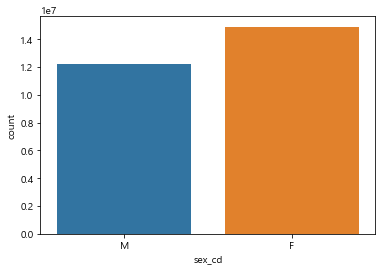

In [58]:
sns.countplot(data=df, x="성별코드")
plt.show()

In [11]:
df.groupby(['성별코드'])['총거래금액'].mean()

sex_cd
F    22919.131814
M    21703.987836
Name: ttl_trns_amt, dtype: float64

<AxesSubplot:xlabel='sex_cd', ylabel='ttl_trns_amt'>

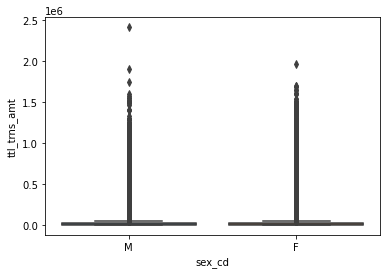

In [10]:
sns.boxplot(x = '성별코드', y = '총거래금액', data = df)

# trns_cnt 거래건수

In [59]:
df.거래건수.unique()

array([ 1,  2,  3,  4,  5,  6, 10,  7,  8, 11, 30,  9, 12, 13, 24, 40, 20,
       15, 14, 21, 16, 17, 19, 18, 22, 28, 55, 23, 31, 26, 29, 37, 34, 27,
       56, 71, 57, 35, 36, 38, 41, 64, 25, 32, 63], dtype=int64)

In [60]:
df['거래건수'].value_counts()

1     24823825
2      1964625
3       264914
4        55319
5        15612
6         5727
7         2323
8         1119
9          569
10         350
11         227
12         136
13         114
14          64
15          47
16          32
17          28
18          18
20          17
19          15
22          11
24          10
21           8
40           6
23           5
30           5
26           4
28           4
31           4
29           3
41           2
27           2
32           2
38           2
64           1
63           1
57           1
56           1
55           1
35           1
37           1
36           1
25           1
34           1
71           1
Name: trns_cnt, dtype: int64

In [24]:
df[df['거래건수']==40]

,strd_date,strd_tizn_val,ctpr_nm,ccg_nm,adn_dgnm,adng_no,cardc_nm,tpbuz_cd,tpbuz_nm,bth_yr,sex_cd,trns_cnt,ttl_trns_amt
300998,20220601,19,부산광역시,금정구,장전1동,21110610,하나,5202,사무용 OA기기,1997,F,40,7000
10251335,20220701,17,부산광역시,동구,수정2동,21030570,부산,4010,편 의 점,1984,F,40,160800
13203105,20220710,15,부산광역시,사상구,주례2동,21150610,코나,9130,사무서비스,2000,F,40,6720
22931710,20220812,9,부산광역시,서구,동대신1동,21020510,부산,4010,편 의 점,1946,F,40,180000
23067550,20220812,16,부산광역시,동구,수정2동,21030570,부산,4010,편 의 점,1984,F,40,172500
26059010,20220825,21,부산광역시,동래구,온천2동,21060560,농협,4010,편 의 점,1980,F,40,127000


# ttl_trns_amt 총거래금액

In [67]:
df.ttl_trns_amt.unique()

array([  7350,   3700,   7500, ...,    579,    997, 106662], dtype=int64)